# LLM Factor Analysis - Personality Items (Qwen3-Embedding Models)

Extracts embeddings from NEO personality items using **Qwen3-Embedding models** and compares predicted similarities with observed correlations.

**Available Models:**
- Qwen3-Embedding-0.6B (600M parameters, ~2.4 GB)
- Qwen3-Embedding-4B (4B parameters, ~16 GB) 
- Qwen3-Embedding-8B (8B parameters, ~32 GB)

**Model Configuration:**
- Precision: FP32 (full precision)
- Library: sentence-transformers (simplified API)
- Supports: 100+ languages, MTEB top-ranked performance

**Note:** You can easily enable/disable specific models in the model selection cell below. By default, all three models are enabled.

## Import Dependencies

This notebook requires:
- `sentence-transformers>=2.7.0`
- `transformers>=4.51.0`
- `torch>=2.0.0`

In [1]:
import os
import sys

import pandas as pd
import numpy as np
print("  - pandas and numpy loaded")

import torch
print(f"  - torch {torch.__version__} loaded")

# Check if sentence-transformers is installed
try:
    from sentence_transformers import SentenceTransformer
    import sentence_transformers
    print(f"  - sentence-transformers {sentence_transformers.__version__} loaded")
except ImportError:
    print("\nERROR: sentence-transformers not found!")
    print("Please install: pip install sentence-transformers>=2.7.0")
    raise

# Check transformers version
import transformers
print(f"  - transformers {transformers.__version__} loaded")

  - pandas and numpy loaded
  - torch 2.9.0 loaded


/Users/devon7y/VS Code/LLM Factor Analysis/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  - sentence-transformers 5.1.1 loaded
  - transformers 4.57.1 loaded


## Load and Process Data

In [2]:
print("Loading scale...")
scale = pd.read_csv('DASS_items.csv', usecols=['code', 'item', 'factor'])
print(f"Loaded {len(scale)} items")

# Preview the data
scale.head()

Loading scale...
Loaded 42 items


,code,item,factor
0,S1,I found myself getting upset by quite trivial ...,Stress
1,A2,I was aware of dryness of my mouth.,Anxiety
2,D3,I couldn't seem to experience any positive fee...,Depression
3,A4,"I experienced breathing difficulty (eg, excess...",Anxiety
4,D5,I just couldn't seem to get going.,Depression


In [3]:
# Extract codes, items and factors for easier access
codes = scale['code'].tolist()
items = scale['item'].tolist()
factors = scale['factor'].tolist()

print(f"Total items: {len(items)}")
print(f"Unique factors: {sorted(set(factors))}")
print(f"Sample codes: {codes[:5]}")

Total items: 42
Unique factors: ['Anxiety', 'Depression', 'Stress']
Sample codes: ['S1', 'A2', 'D3', 'A4', 'D5']


## Device Detection and Memory Check

In [4]:
# Detect available device
print("Detecting available device...")
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"✓ Using CUDA GPU: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("✓ Using Apple MPS GPU (Metal Performance Shaders)")
else:
    device = torch.device('cpu')
    print("✓ Using CPU")

# Check available memory (basic check)
try:
    import psutil
    mem = psutil.virtual_memory()
    print(f"\nSystem Memory:")
    print(f"  Total: {mem.total / (1024**3):.1f} GB")
    print(f"  Available: {mem.available / (1024**3):.1f} GB")
    print(f"  Used: {mem.percent}%")
except ImportError:
    print("\n  psutil not installed - skipping memory check")
    print("Install with: pip install psutil")

Detecting available device...
✓ Using Apple MPS GPU (Metal Performance Shaders)

System Memory:
  Total: 16.0 GB
  Available: 2.4 GB
  Used: 84.9%


## Load Qwen3-Embedding Models

**Memory Requirements (FP32 full precision):**
- Qwen3-Embedding-0.6B: ~2.4 GB
- Qwen3-Embedding-4B: ~16 GB
- Qwen3-Embedding-8B: ~32 GB

We'll load and process each model sequentially to analyze how model size affects embedding quality.

In [5]:
# Define the models to test
model_names = [
    "Qwen/Qwen3-Embedding-0.6B"
]

#model_names = [
#    "Qwen/Qwen3-Embedding-0.6B",
#    "Qwen/Qwen3-Embedding-4B", 
#    "Qwen/Qwen3-Embedding-8B"
#]

# Dictionary to store results
all_embeddings = {}
all_models = {}

print("Loading Qwen3-Embedding models with FP32 (full precision)...")
print("=" * 70)

for model_name in model_names:
    model_size = model_name.split("-")[-1]
    print(f"\n{'='*70}")
    print(f"Loading {model_name}")
    print(f"{'='*70}")
    print(f"This may take 30-120 seconds depending on model size...")
    
    try:
        # Load model with FP32 (full precision)
        model = SentenceTransformer(
            model_name,
            model_kwargs={
                "device_map": "auto",  # Automatically map to GPU/CPU
            },
            # No dtype specified = FP32 by default
        )
        
        print(f"✓ {model_size} model loaded successfully!")
        print(f"  Device: {model.device}")
        print(f"  Max sequence length: {model.max_seq_length}")
        
        # Check embedding dimension
        test_embedding = model.encode(["test"], convert_to_numpy=True)
        print(f"  Embedding dimension: {test_embedding.shape[1]}")
        
        # Store the model for later use
        all_models[model_size] = model
        
    except Exception as e:
        print(f"\n  Error loading {model_name}:")
        print(f"  {str(e)}")
        raise

print(f"\n{'='*70}")
print(f"✓ All {len(all_models)} models loaded successfully!")
print(f"{'='*70}")

Loading Qwen3-Embedding models with FP32 (full precision)...

Loading Qwen/Qwen3-Embedding-0.6B
This may take 30-120 seconds depending on model size...
✓ 0.6B model loaded successfully!
  Device: mps:0
  Max sequence length: 32768
  Embedding dimension: 1024

✓ All 1 models loaded successfully!


## Configure and Load Qwen3-Embedding Models

**Memory Requirements (FP32 full precision):**
- Qwen3-Embedding-0.6B: ~2.4 GB
- Qwen3-Embedding-4B: ~16 GB
- Qwen3-Embedding-8B: ~32 GB

**How to select models:**
- In the cell below, you can easily enable/disable models by commenting/uncommenting lines
- Simply add `#` at the start of a line to disable that model
- Remove `#` to enable a model
- The notebook will automatically adapt to run 1, 2, or all 3 models

In [ ]:
# ============================================================================
# MODEL SELECTION - Comment out any models you don't want to run
# ============================================================================
# To disable a model, add a '#' at the start of its line
# To enable a model, remove the '#' from the start of its line
# ============================================================================

model_names = [
    "Qwen/Qwen3-Embedding-0.6B",
    "Qwen/Qwen3-Embedding-4B", 
    "Qwen/Qwen3-Embedding-8B"
]

# ============================================================================

# Dictionary to store results
all_embeddings = {}
all_models = {}

print(f"Loading {len(model_names)} Qwen3-Embedding model(s)...")
print("=" * 70)
print(f"Selected models: {[m.split('/')[-1] for m in model_names]}")
print("=" * 70)

for model_name in model_names:
    model_size = model_name.split("-")[-1]
    print(f"\n{'='*70}")
    print(f"Loading {model_name}")
    print(f"{'='*70}")
    print(f"This may take 30-120 seconds depending on model size...")
    
    try:
        # Load model - let sentence-transformers handle device placement automatically
        # Don't use device_map="auto" as it causes meta tensor issues with large models
        model = SentenceTransformer(model_name)
        
        print(f"✓ {model_size} model loaded successfully!")
        print(f"  Device: {model.device}")
        print(f"  Max sequence length: {model.max_seq_length}")
        
        # Check embedding dimension
        test_embedding = model.encode(["test"], convert_to_numpy=True)
        print(f"  Embedding dimension: {test_embedding.shape[1]}")
        
        # Store the model for later use
        all_models[model_size] = model
        
    except Exception as e:
        print(f"\nError loading {model_name}:")
        print(f"  {type(e).__name__}: {str(e)}")
        print(f"  Skipping this model and continuing with others...")
        continue

print(f"\n{'='*70}")
print(f"✓ Successfully loaded {len(all_models)} model(s)!")
print(f"{'='*70}")

## Extract Embeddings for All Models

Using sentence-transformers' `encode()` method for each model.

**Processing:**
- Extract embeddings for all personality items with each model
- Using `batch_size=8` for efficient processing
- Results stored in `all_embeddings` dictionary keyed by model size

In [7]:
print(f"Extracting embeddings for {len(items)} personality items using all models...")
print("=" * 70)

for model_size, model in all_models.items():
    print(f"\n{'='*70}")
    print(f"Processing with {model_size} model")
    print(f"{'='*70}")
    
    try:
        # Extract embeddings
        embeddings = model.encode(
            items,
            batch_size=8,  # Process in batches
            show_progress_bar=True,
            convert_to_numpy=True,
            normalize_embeddings=False  # Keep raw embeddings for analysis
        )
        
        # Store results
        all_embeddings[model_size] = embeddings
        
        print(f"\n✓ Embedding extraction complete for {model_size}!")
        print(f"  Shape: {embeddings.shape}")
        print(f"  ({embeddings.shape[0]} items × {embeddings.shape[1]} dimensions)")
        
    except RuntimeError as e:
        if "out of memory" in str(e).lower():
            print(f"\nOut of memory error with {model_size}!")
            print(f"  Try reducing batch_size or using a smaller model")
            raise
        else:
            raise

print(f"\n{'='*70}")
print(f"✓ All embeddings extracted successfully!")
print(f"{'='*70}")
print(f"\nEmbedding dimensions by model:")
for model_size, embeddings in all_embeddings.items():
    print(f"  {model_size}: {embeddings.shape[1]}D")

Extracting embeddings for 42 personality items using all models...

Processing with 0.6B model


Batches: 100%|██████████| 6/6 [00:09<00:00,  1.62s/it]


✓ Embedding extraction complete for 0.6B!
  Shape: (42, 1024)
  (42 items × 1024 dimensions)

✓ All embeddings extracted successfully!

Embedding dimensions by model:
  0.6B: 1024D


## Inspect Embedding Results

In [8]:
# Compare embedding dimensions across models
print("Embedding dimensions by model:")
print("=" * 70)
for model_size, embeddings in all_embeddings.items():
    print(f"\n{model_size}:")
    print(f"  Shape: {embeddings.shape}")
    print(f"  Embedding dimension: {embeddings.shape[1]}D")
    print(f"  First embedding (first 10 values): {embeddings[0][:10]}")

Embedding dimensions by model:

0.6B:
  Shape: (42, 1024)
  Embedding dimension: 1024D
  First embedding (first 10 values): [ 0.01202668 -0.0104402  -0.00594882  0.03350148  0.01650581 -0.02499348
  0.02960537 -0.03747144 -0.07596644  0.06410423]


In [9]:
# Summary statistics for all models
print("Embedding statistics by model:")
print("=" * 70)
for model_size, embeddings in all_embeddings.items():
    print(f"\n{model_size}:")
    print(f"  Min value: {embeddings.min():.4f}")
    print(f"  Max value: {embeddings.max():.4f}")
    print(f"  Mean: {embeddings.mean():.4f}")
    print(f"  Std: {embeddings.std():.4f}")

Embedding statistics by model:

0.6B:
  Min value: -0.1468
  Max value: 0.1739
  Mean: -0.0004
  Std: 0.0312


In [10]:
# Check a specific item across all models
sample_idx = 0
print(f"Sample item #{sample_idx}:")
print(f"  Factor: {factors[sample_idx]}")
print(f"  Text: {items[sample_idx]}")
print("\nEmbedding properties by model:")
print("=" * 70)

for model_size, embeddings in all_embeddings.items():
    print(f"\n{model_size}:")
    print(f"  Embedding shape: {embeddings[sample_idx].shape}")
    print(f"  Embedding norm: {np.linalg.norm(embeddings[sample_idx]):.4f}")

Sample item #0:
  Factor: Stress
  Text: I found myself getting upset by quite trivial things.

Embedding properties by model:

0.6B:
  Embedding shape: (1024,)
  Embedding norm: 1.0000


## T-SNE Visualization - All Models

Visualize the high-dimensional embeddings in 2D space using T-SNE, color-coded by personality factor.

We'll create separate T-SNE plots for each model to compare how different model sizes capture semantic relationships.

In [11]:
# Import visualization libraries
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

print("Visualization libraries loaded")

Visualization libraries loaded


In [12]:
# Prepare data for T-SNE (same across all models)
print("Preparing data for T-SNE...")
print(f"Number of items: {len(factors)}")

# Get unique factors for legend
unique_factors = sorted(set(factors))
print(f"Personality factors: {unique_factors}")

# Create a color map for the personality factors
import matplotlib.cm as cm
colors_map = cm.get_cmap('tab10', len(unique_factors))
factor_to_color = {factor: colors_map(i) for i, factor in enumerate(unique_factors)}

Preparing data for T-SNE...
Number of items: 42
Personality factors: ['Anxiety', 'Depression', 'Stress']


/var/folders/tw/9fmk8_cs08v70918my8dtdmh0000gn/T/ipykernel_26603/4078075515.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_map = cm.get_cmap('tab10', len(unique_factors))


In [13]:
# Run T-SNE and create visualizations for all models
print("Running T-SNE for all models...")
print("=" * 70)

all_tsne_embeddings = {}

for model_size, embeddings in all_embeddings.items():
    print(f"\n{'='*70}")
    print(f"Running T-SNE for {model_size} model...")
    print(f"{'='*70}")
    print(f"Input shape: {embeddings.shape}")
    
    # Run T-SNE dimensionality reduction
    tsne = TSNE(
        n_components=2,      # Reduce to 2D
        perplexity=30,       # Balance local vs global structure
        max_iter=1000,       # Number of iterations
        random_state=42,     # For reproducibility
        verbose=1            # Show progress
    )
    
    # Transform high-D embeddings to 2D
    embeddings_2d = tsne.fit_transform(embeddings)
    all_tsne_embeddings[model_size] = embeddings_2d
    
    print(f"✓ T-SNE complete! 2D embeddings shape: {embeddings_2d.shape}")

print(f"\n{'='*70}")
print(f"✓ T-SNE complete for all {len(all_tsne_embeddings)} models!")
print(f"{'='*70}")

Running T-SNE for all models...

Running T-SNE for 0.6B model...
Input shape: (42, 1024)
[t-SNE] Computing 41 nearest neighbors...
[t-SNE] Indexed 42 samples in 0.011s...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[t-SNE] Computed neighbors for 42 samples in 0.183s...
[t-SNE] Computed conditional probabilities for sample 42 / 42
[t-SNE] Mean sigma: 0.476257
[t-SNE] KL divergence after 250 iterations with early exaggeration: 42.584194
[t-SNE] KL divergence after 1000 iterations: 0.069808
✓ T-SNE complete! 2D embeddings shape: (42, 2)

✓ T-SNE complete for all 1 models!


Creating visualizations...


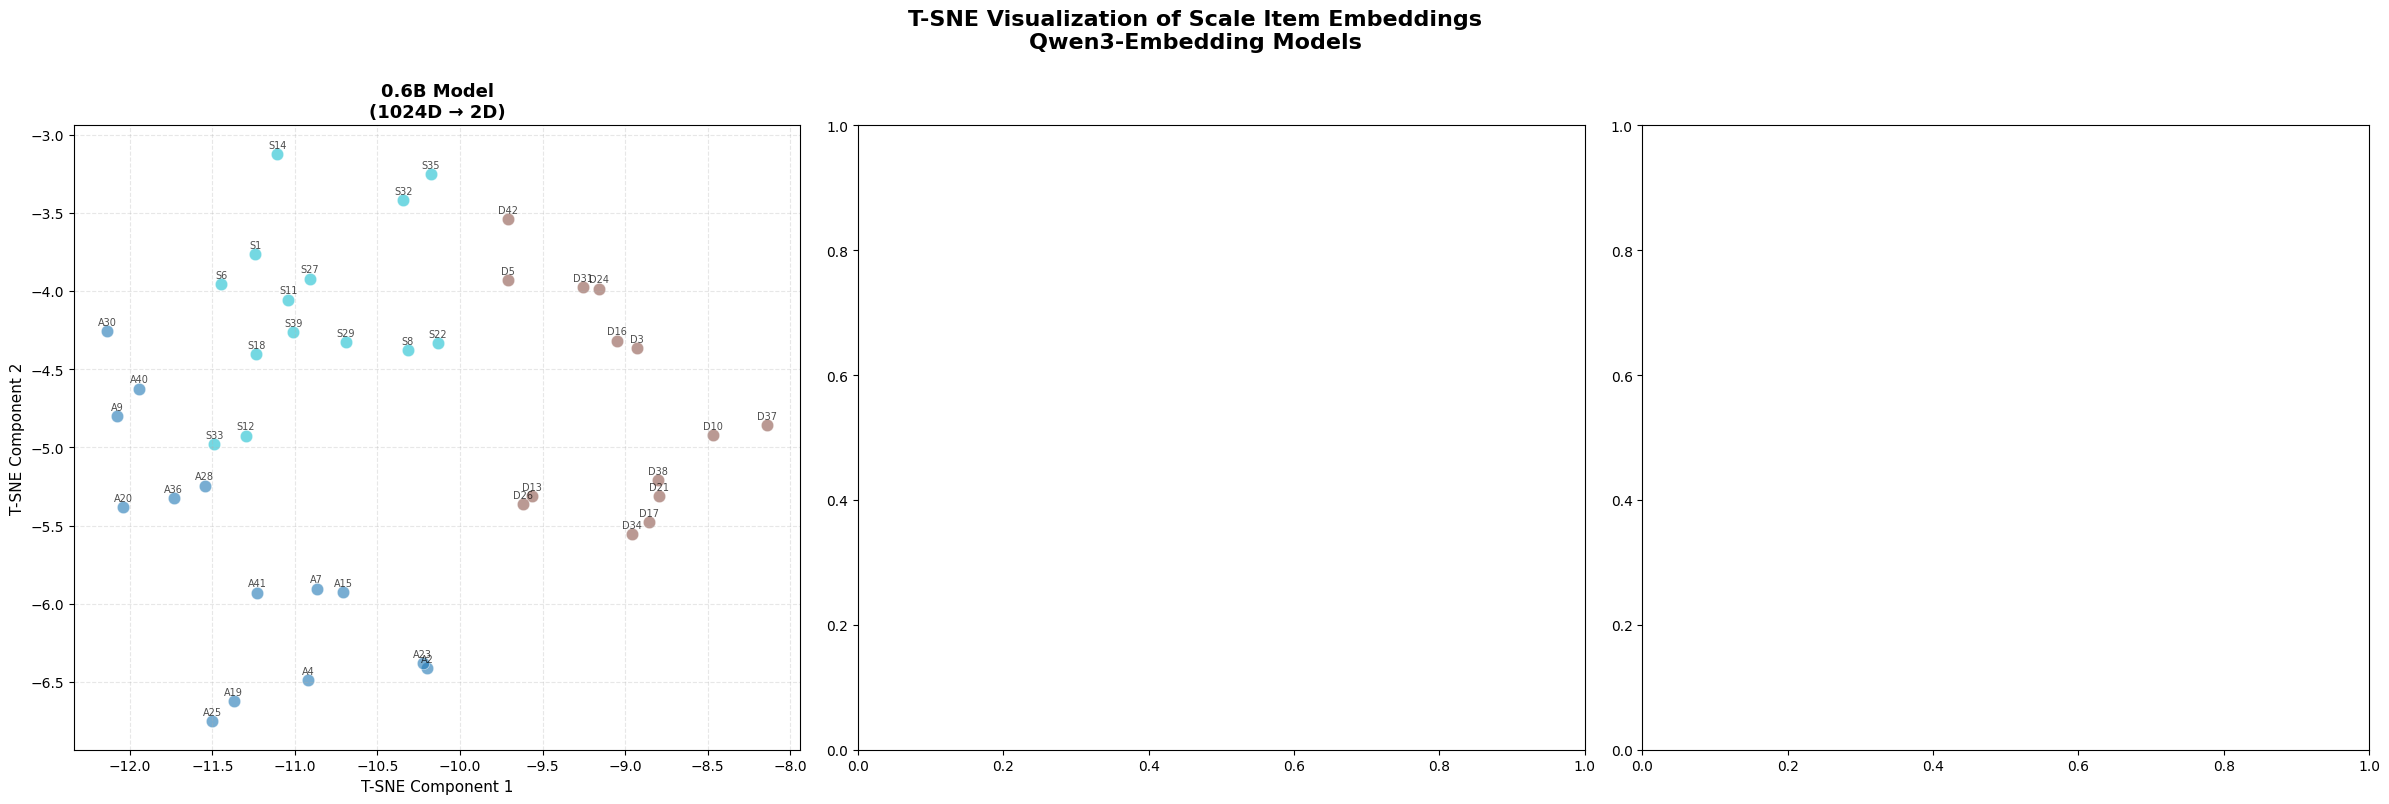


✓ Visualization complete!


In [14]:
# Create T-SNE scatter plots for all models
print("Creating visualizations...")
print("=" * 70)

# Create a figure with subplots (one for each model)
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

for idx, (model_size, embeddings_2d) in enumerate(sorted(all_tsne_embeddings.items())):
    ax = axes[idx]
    
    # Plot each factor with a different color
    for factor in unique_factors:
        # Get indices for this factor
        indices = [i for i, f in enumerate(factors) if f == factor]
        
        # Plot points for this factor
        ax.scatter(
            embeddings_2d[indices, 0],
            embeddings_2d[indices, 1],
            c=[factor_to_color[factor]],
            label=factor,
            alpha=0.6,
            s=80,
            edgecolors='white',
            linewidth=0.5
        )
    
    # Add labels for each point using the 'code' column
    for i in range(len(embeddings_2d)):
        ax.annotate(
            codes[i],  # Use the code as the label
            (embeddings_2d[i, 0], embeddings_2d[i, 1]),
            fontsize=7,
            alpha=0.7,
            ha='center',
            va='bottom',
            xytext=(0, 3),  # Offset label slightly above the point
            textcoords='offset points'
        )
    
    # Get embedding dimension for title
    embedding_dim = all_embeddings[model_size].shape[1]
    
    ax.set_xlabel('T-SNE Component 1', fontsize=11)
    ax.set_ylabel('T-SNE Component 2', fontsize=11)
    ax.set_title(
        f'{model_size} Model\n({embedding_dim}D → 2D)',
        fontsize=13,
        fontweight='bold'
    )
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Only add legend to the rightmost plot
    if idx == 2:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Overall title
fig.suptitle(
    'T-SNE Visualization of Scale Item Embeddings\n'
    'Qwen3-Embedding Models',
    fontsize=16,
    fontweight='bold',
    y=1.00
)

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete!")

## Analyze Nearest Neighbors - All Models

Compare how different model sizes identify semantic neighbors.

Creating visualizations...
Creating plots for 1 model(s)...


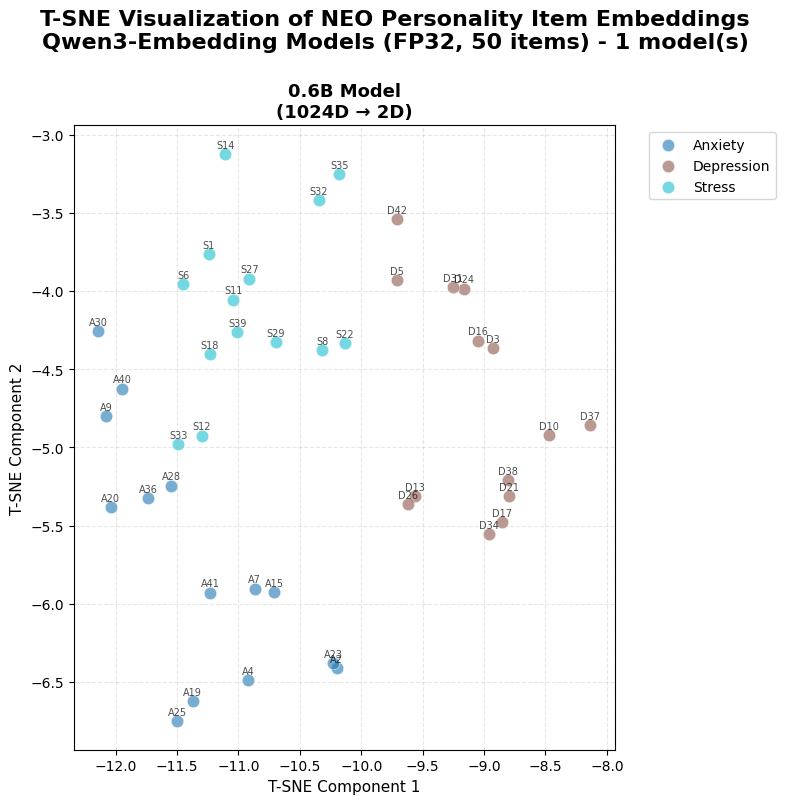


✓ Visualization complete!


In [15]:
# Create T-SNE scatter plots for all models
print("Creating visualizations...")
print("=" * 70)

# Determine number of models and create appropriate figure
num_models = len(all_tsne_embeddings)
print(f"Creating plots for {num_models} model(s)...")

# Adjust figure size based on number of models
fig_width = 8 * num_models  # 8 inches per model
fig, axes = plt.subplots(1, num_models, figsize=(fig_width, 8))

# Handle case of single model (axes is not a list in this case)
if num_models == 1:
    axes = [axes]

for idx, (model_size, embeddings_2d) in enumerate(sorted(all_tsne_embeddings.items())):
    ax = axes[idx]
    
    # Plot each factor with a different color
    for factor in unique_factors:
        # Get indices for this factor
        indices = [i for i, f in enumerate(factors) if f == factor]
        
        # Plot points for this factor
        ax.scatter(
            embeddings_2d[indices, 0],
            embeddings_2d[indices, 1],
            c=[factor_to_color[factor]],
            label=factor,
            alpha=0.6,
            s=80,
            edgecolors='white',
            linewidth=0.5
        )
    
    # Add labels for each point using the 'code' column
    for i in range(len(embeddings_2d)):
        ax.annotate(
            codes[i],  # Use the code as the label
            (embeddings_2d[i, 0], embeddings_2d[i, 1]),
            fontsize=7,
            alpha=0.7,
            ha='center',
            va='bottom',
            xytext=(0, 3),  # Offset label slightly above the point
            textcoords='offset points'
        )
    
    # Get embedding dimension for title
    embedding_dim = all_embeddings[model_size].shape[1]
    
    ax.set_xlabel('T-SNE Component 1', fontsize=11)
    ax.set_ylabel('T-SNE Component 2', fontsize=11)
    ax.set_title(
        f'{model_size} Model\n({embedding_dim}D → 2D)',
        fontsize=13,
        fontweight='bold'
    )
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Add legend to the rightmost plot
    if idx == num_models - 1:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Overall title
fig.suptitle(
    'T-SNE Visualization of NEO Personality Item Embeddings\n'
    f'Qwen3-Embedding Models (FP32, 50 items) - {num_models} model(s)',
    fontsize=16,
    fontweight='bold',
    y=1.00
)

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete!")

In [17]:
# Analyze nearest neighbors in the ORIGINAL high-dimensional space for all models
print("Finding nearest neighbors in original embedding space (not T-SNE)...")
print("=" * 70)

from sklearn.metrics.pairwise import cosine_similarity

print(f"\nSample item #{sample_idx}:")
print(f"  Factor: {factors[sample_idx]}")
print(f"  Text: {items[sample_idx]}")

for model_size, embeddings in sorted(all_embeddings.items()):
    print(f"\n{'='*70}")
    print(f"{model_size} Model - Original {embeddings.shape[1]}D Space")
    print(f"{'='*70}")
    
    # Compute cosine similarity between sample and all items
    similarities = cosine_similarity([embeddings[sample_idx]], embeddings)[0]
    
    # Find 5 most similar items (excluding itself)
    most_similar_indices = np.argsort(similarities)[::-1][1:6]
    
    print(f"5 Most similar items (by cosine similarity):")
    for rank, idx in enumerate(most_similar_indices, 1):
        print(f"  {rank}. [{factors[idx]}] {items[idx]}")
        print(f"      Similarity: {similarities[idx]:.4f}")

Finding nearest neighbors in original embedding space (not T-SNE)...

Sample item #0:
  Factor: Stress
  Text: I found myself getting upset by quite trivial things.

0.6B Model - Original 1024D Space
5 Most similar items (by cosine similarity):
  1. [Stress] I found myself getting upset rather easily.
      Similarity: 0.8722
  2. [Stress] I found myself getting agitated.
      Similarity: 0.7611
  3. [Stress] I found that I was very irritable.
      Similarity: 0.7597
  4. [Stress] I found it hard to calm down after something upset me.
      Similarity: 0.7579
  5. [Stress] I felt that I was rather touchy.
      Similarity: 0.7467


## Quantify Factor Separation

Measure how well the embeddings separate the three DASS factors (Anxiety, Depression, Stress) using cosine similarity analysis.

**Metrics:**
- **Within-factor similarity**: Average cosine similarity between items in the same factor
- **Between-factor similarity**: Average cosine similarity between items in different factors  
- **Separation ratio**: Within / Between (higher = better separation, >1.0 means factors cluster together)

In [18]:
print("Computing factor separation metrics...")
print("=" * 70)

# Loop through all models
for model_size, embeddings in sorted(all_embeddings.items()):
    print(f"\n{'='*70}")
    print(f"{model_size} Model - Factor Separation Analysis")
    print(f"{'='*70}")
    
    # Compute full similarity matrix
    sim_matrix = cosine_similarity(embeddings)
    
    # Initialize accumulators
    within_factor_sims = {factor: [] for factor in unique_factors}
    between_factor_sims = []
    
    # Compute within-factor and between-factor similarities
    for i in range(len(items)):
        for j in range(i + 1, len(items)):  # Only upper triangle (avoid duplicates)
            similarity = sim_matrix[i, j]
            
            if factors[i] == factors[j]:
                # Same factor - within-factor similarity
                within_factor_sims[factors[i]].append(similarity)
            else:
                # Different factors - between-factor similarity
                between_factor_sims.append(similarity)
    
    # Compute overall metrics
    all_within_sims = []
    for factor_sims in within_factor_sims.values():
        all_within_sims.extend(factor_sims)
    
    within_mean = np.mean(all_within_sims)
    between_mean = np.mean(between_factor_sims)
    separation_ratio = within_mean / between_mean
    
    # Print overall results
    print(f"\nOverall Separation Metrics:")
    print(f"  Within-factor similarity:  {within_mean:.4f}")
    print(f"  Between-factor similarity: {between_mean:.4f}")
    print(f"  Separation ratio:          {separation_ratio:.4f}")
    print(f"    {'(Good separation - factors cluster together!)' if separation_ratio > 1.0 else '(Poor separation - factors overlap)'}")
    
    # Print per-factor breakdown
    print(f"\nPer-Factor Within-Similarity:")
    for factor in unique_factors:
        factor_mean = np.mean(within_factor_sims[factor])
        factor_std = np.std(within_factor_sims[factor])
        n_pairs = len(within_factor_sims[factor])
        print(f"  {factor:12s}: {factor_mean:.4f} ± {factor_std:.4f}  (n={n_pairs} pairs)")
    
    # Compute pairwise between-factor similarities
    print(f"\nBetween-Factor Similarities:")
    factor_pairs = {}
    for i in range(len(items)):
        for j in range(i + 1, len(items)):
            if factors[i] != factors[j]:
                pair = tuple(sorted([factors[i], factors[j]]))
                if pair not in factor_pairs:
                    factor_pairs[pair] = []
                factor_pairs[pair].append(sim_matrix[i, j])
    
    for pair in sorted(factor_pairs.keys()):
        pair_mean = np.mean(factor_pairs[pair])
        pair_std = np.std(factor_pairs[pair])
        n_pairs = len(factor_pairs[pair])
        print(f"  {pair[0]:12s} vs {pair[1]:12s}: {pair_mean:.4f} ± {pair_std:.4f}  (n={n_pairs} pairs)")

print(f"\n{'='*70}")
print("Factor separation analysis complete!")
print(f"{'='*70}")

Computing factor separation metrics...

0.6B Model - Factor Separation Analysis

Overall Separation Metrics:
  Within-factor similarity:  0.6528
  Between-factor similarity: 0.5538
  Separation ratio:          1.1788
    (Good separation - factors cluster together!)

Per-Factor Within-Similarity:
  Anxiety     : 0.6009 ± 0.0940  (n=91 pairs)
  Depression  : 0.6577 ± 0.0963  (n=91 pairs)
  Stress      : 0.6998 ± 0.0778  (n=91 pairs)

Between-Factor Similarities:
  Anxiety      vs Depression  : 0.5140 ± 0.0640  (n=196 pairs)
  Anxiety      vs Stress      : 0.5814 ± 0.0768  (n=196 pairs)
  Depression   vs Stress      : 0.5659 ± 0.0703  (n=196 pairs)

Factor separation analysis complete!


## Calculate Factor Centroids

Compute the mean embedding (centroid) for each of the three DASS factors. These centroids represent the "average" embedding for each psychological dimension and can be used for further analysis.

In [19]:
print("Calculating factor centroids...")
print("=" * 70)

# Dictionary to store centroids for all models
all_centroids = {}

# Loop through all models
for model_size, embeddings in sorted(all_embeddings.items()):
    print(f"\n{'='*70}")
    print(f"{model_size} Model - Computing Centroids")
    print(f"{'='*70}")
    
    # Initialize centroid dictionary for this model
    centroids = {}
    
    # Calculate centroid (mean embedding) for each factor
    for factor in unique_factors:
        # Get indices of items belonging to this factor
        factor_indices = [i for i, f in enumerate(factors) if f == factor]
        
        # Get embeddings for this factor
        factor_embeddings = embeddings[factor_indices]
        
        # Compute centroid (mean of all embeddings in this factor)
        centroid = np.mean(factor_embeddings, axis=0)
        
        # Store centroid
        centroids[factor] = centroid
        
        # Print info
        print(f"\n{factor}:")
        print(f"  Number of items: {len(factor_indices)}")
        print(f"  Centroid shape: {centroid.shape}")
        print(f"  Centroid norm: {np.linalg.norm(centroid):.4f}")
    
    # Store centroids for this model
    all_centroids[model_size] = centroids

print(f"\n{'='*70}")
print("Centroid calculation complete!")
print(f"{'='*70}")
print(f"\nCentroids stored in 'all_centroids' dictionary:")
print(f"  Structure: all_centroids[model_size][factor] = centroid_vector")
print(f"  Models: {list(all_centroids.keys())}")
print(f"  Factors per model: {list(all_centroids[list(all_centroids.keys())[0]].keys())}")

Calculating factor centroids...

0.6B Model - Computing Centroids

Anxiety:
  Number of items: 14
  Centroid shape: (1024,)
  Centroid norm: 0.7933

Depression:
  Number of items: 14
  Centroid shape: (1024,)
  Centroid norm: 0.8259

Stress:
  Number of items: 14
  Centroid shape: (1024,)
  Centroid norm: 0.8492

Centroid calculation complete!

Centroids stored in 'all_centroids' dictionary:
  Structure: all_centroids[model_size][factor] = centroid_vector
  Models: ['0.6B']
  Factors per model: ['Anxiety', 'Depression', 'Stress']
